#### This is a jupyter notebook to show some of the preprocessing steps of Head localization (identification) of hajis (pilgrims)
<br>
Image Preprocessing involves cleaning the image, removing unwanted noise through mathematical models and reducing the dimensions of the data. In this notebook, I take you through converting the given hajj image to grayscale, finding out the magnitude of the gradient and also finding out the threshold for binarizing the image.

In [1]:
from skimage import io
from skimage import filters
from skimage import segmentation
from skimage import color
import numpy as np
from scipy.signal import convolve
import matplotlib.pyplot as plt
from scipy import ndimage

%matplotlib inline

#### Read and display the image 

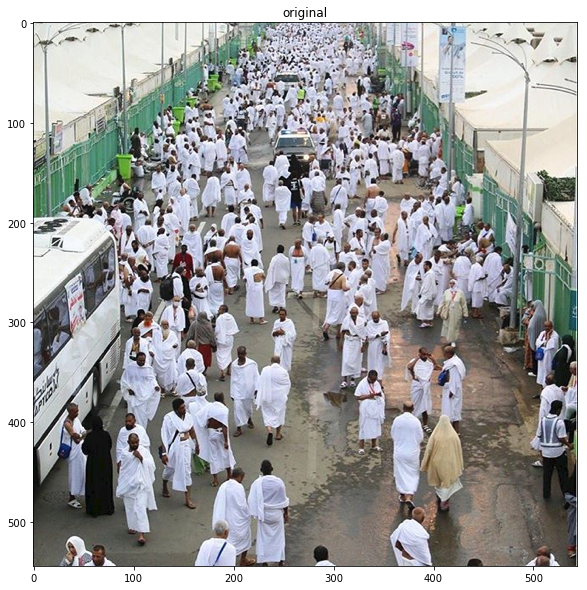

In [2]:
hajj_img = io.imread("mina_street.png")
plt.figure(figsize=(10,10))
plt.title('original')
plt.imshow(hajj_img)
plt.show()

#### Convert the image from RGB to grayscale and render it

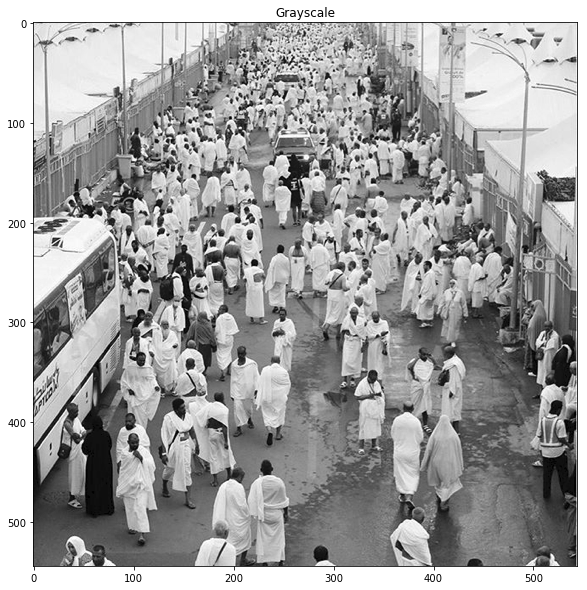

In [3]:
hajj_img_gray = color.rgb2gray(hajj_img)
plt.figure(figsize=(10,10))
plt.imshow(hajj_img_gray)
plt.title('Grayscale')
plt.gray()
plt.show()

#### Create a Mean kernel to convolve over the given image to find the ideal threshold using Sauvola algorithm <br>
This is my own implementation of the Sauvola algorithm. It's theoretical details can be found here<br>
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.98.880&rep=rep1&type=pdf

It is based on the equation $$\mathbf{T} = \mathbf{M}\left(1 +\ k\times\left(\frac{\mathbf{S}}{\mathbf{R}} -\ 1\right)\right)$$

<br>
Where **T** is the Threshold <br>
**M** is the Mean of the kernel<br>
**_k_** is the co-efficient of thickness<br>
**S** is the Standard deviation <br>
**R** is the Range of values in the kernel<br>

In [4]:
def get_mean_kernel(shape):
    kernel = np.ones((shape[0],shape[1]), np.float32)
    kernel = kernel/np.sum(kernel)
    return kernel

mean_kernel = get_mean_kernel((20,20))

def thariq_sauvola(gim, mean_kernel, k = 0.2):
    im2 = gim**2
    expI = convolve(gim, mean_kernel, mode='same')
    expI2 = convolve(im2, mean_kernel, mode='same')

    S = np.sqrt(expI2 - np.square(expI) + 1e-8)
    R = gim.max() - gim.min()
    
    M = convolve(gim, mean_kernel, mode='same')
    
    T = M*(1 + k*((S/R) - 1))
    
    sauvola_im = gim < T
    return sauvola_im

##### Custom function to display 2 images together

In [5]:
def display_images(img1,img2,img1_title,img2_title):
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.title(img1_title)
    plt.imshow(img1)
    plt.subplot(122)
    plt.title(img2_title)
    plt.imshow(img2)
    plt.gray()
    plt.show()

#### The gradients are found as the first step to find the segmentation boundaries. <br>
Ideally this is what the first layer of a Deep Neural Network does. Here I have demonstrated it by finding out the gradients along the X and Y axes so as to give the idea of how it happens. Different methods can be deployed to find out the gradients. Here it is just the grdient magnitude that is calculated.

In order to demonstrate the gradient finding with Neural Network, we require huge data.

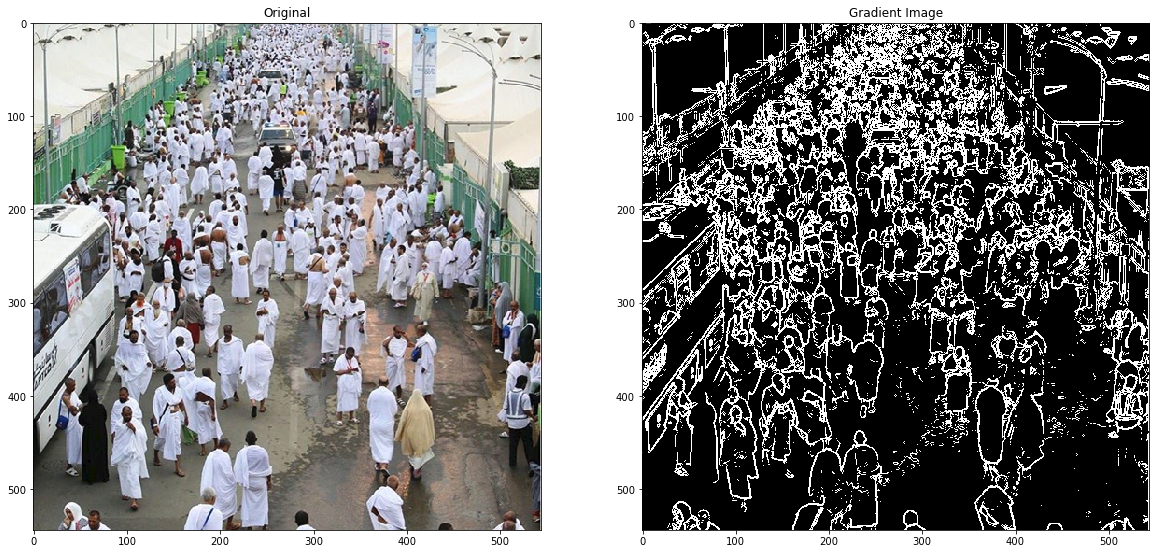

In [6]:
gy, gx = np.gradient(hajj_img_gray)
gmag = np.sqrt(gx**2 + gy**2)
grad_im = gmag > 0.1

display_images(hajj_img,grad_im,img1_title='Original',img2_title='Gradient Image')

#### Thresholding
A threshold is found so as to binarize an image. In this problem it will help in finding out the dark condensed patches
which would denote the locations of heads of people

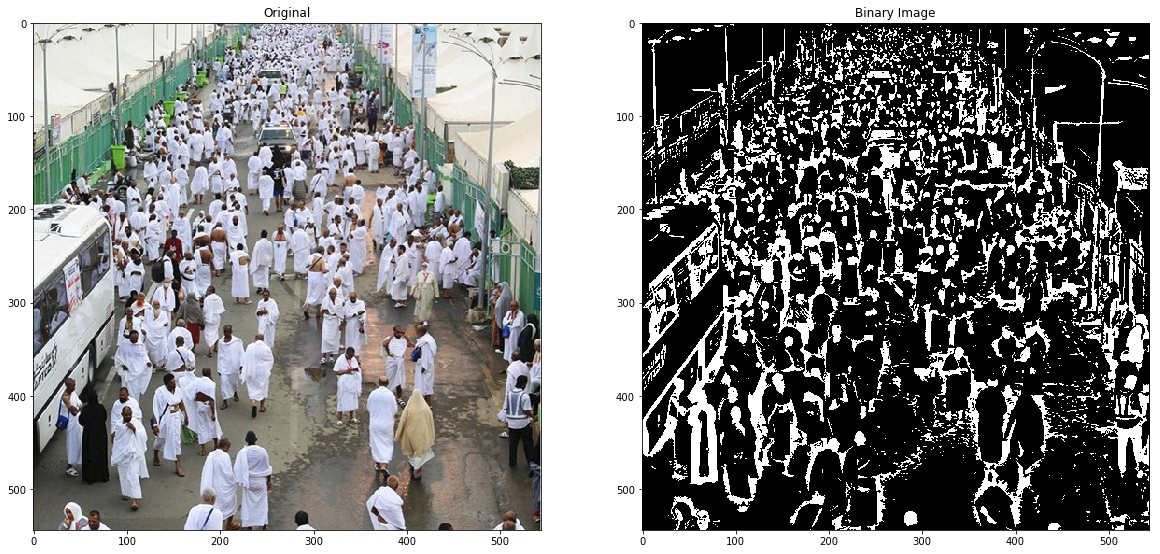

In [7]:
thresholded_im = hajj_img_gray < thariq_sauvola(hajj_img_gray,mean_kernel)

display_images(hajj_img,thresholded_im, img1_title='Original', img2_title='Binary Image')

In [8]:
#function to find out the connected components and then find the heads
label_img, obj_count = ndimage.label(thresholded_im)

In [9]:
print obj_count

2601


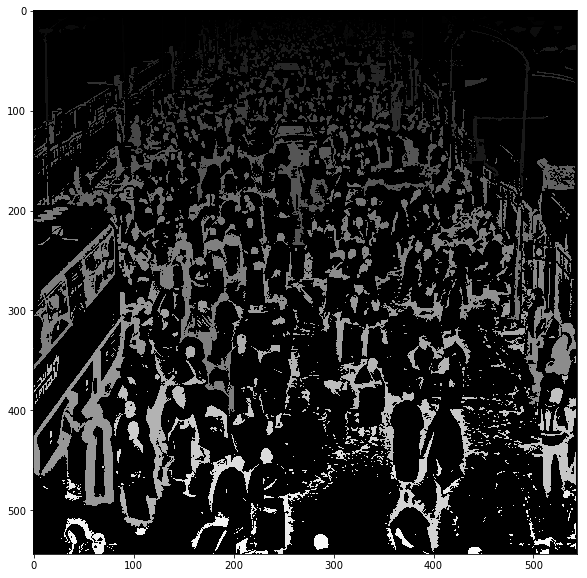

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(label_img,'gray')
plt.show()

### TODO: 
#### Create a mask that is circular in shape so as to detect the heads

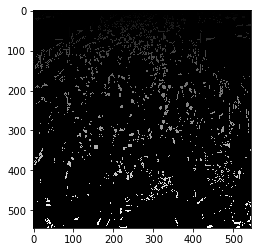

In [11]:
sizes = ndimage.sum(thresholded_im, label_img, range(obj_count + 1))
mask_size = sizes > 100
remove_pixel = mask_size[label_img]
remove_pixel.shape

label_img[remove_pixel] = 1
plt.imshow(label_img)
plt.show()